Combines frozen YAMNet + Scaler + Classifier → TensorFlow SavedModel

Supports: LogisticRegression (TF ops), Others → Keras MLP (retrained)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import warnings

warnings.filterwarnings('ignore')

# -------------------------- PATHS --------------------------
MODELS_DIR       = '../models/models_approach1'
RESULTS_DIR      = '../results/results_approach1'
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, 'saved_models')
YAMNET_URL       = 'https://tfhub.dev/google/yamnet/1'
FEATURES_DIR     = '../data/approach1/features'

os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR,    exist_ok=True)

In [2]:
# -------------------------- LOAD COMPONENTS --------------------------
label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
scaler        = joblib.load(os.path.join(MODELS_DIR, 'feature_scaler.pkl'))
comparison_df = pd.read_csv(os.path.join(RESULTS_DIR, 'model_comparison.csv'))

# Load *sklearn* classifiers (only needed for the original scores)
classifiers = {}
for name in comparison_df['Model']:
    path = os.path.join(MODELS_DIR, f'{name.lower()}_model.pkl')
    classifiers[name] = joblib.load(path)

# Load YAMNet once – shared by every full model
yamnet = hub.load(YAMNET_URL)
print("YAMNet loaded")

# -------------------------- LOAD FEATURES --------------------------
print("\nLoading train / val features …")
X_train = np.load(os.path.join(FEATURES_DIR, 'train', 'yamnet_features.npy'))
y_train = np.load(os.path.join(FEATURES_DIR, 'train', 'yamnet_labels.npy'))
X_val   = np.load(os.path.join(FEATURES_DIR, 'val',   'yamnet_features.npy'))
y_val   = np.load(os.path.join(FEATURES_DIR, 'val',   'yamnet_labels.npy'))

y_train_enc = label_encoder.transform(y_train)
y_val_enc   = label_encoder.transform(y_val)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
print("Features scaled")

YAMNet loaded

Loading train / val features …
Features scaled


In [3]:
# -------------------------- TEMPERATURE CALIBRATION --------------------------
def calibrate_temperature(logits: np.ndarray, true_labels: np.ndarray) -> float:
    def nll(T):
        scaled = logits / T
        log_probs = tf.nn.log_softmax(scaled).numpy()
        true_log_probs = log_probs[np.arange(len(true_labels)), true_labels]
        return -np.mean(true_log_probs)

    res = optimize.minimize_scalar(nll, bounds=(0.01, 10.0), method='bounded')
    return float(res.x)

# -------------------------- CUSTOM YAMNET LAYER --------------------------
@tf.keras.utils.register_keras_serializable()
class YamnetEmbedding(tf.keras.layers.Layer):
    def __init__(self, yamnet_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model = yamnet_model

    def call(self, inputs):
        def _single(wave):
            _, embeddings, _ = self.yamnet_model(wave)
            return tf.reduce_mean(embeddings, axis=0)          # (1024,)
        return tf.map_fn(_single, inputs, dtype=tf.float32)

# -------------------------- BUILD / RETRAIN KERAS CLASSIFIERS --------------------------
print("\n=== BUILDING KERAS CLASSIFIERS (logits) ===")

keras_classifiers = {}   # <-- ONLY KERAS objects go here
temperatures      = {}
results_comparison = []

for name, clf in classifiers.items():
    print(f"\n→ {name}")

    # ---- 1. Original sklearn performance (for the table) ----
    orig_pred = clf.predict(X_val_scaled)
    orig_acc  = accuracy_score(y_val_enc, orig_pred)
    orig_f1   = f1_score(y_val_enc, orig_pred, average='macro')
    print(f"  Original | Acc: {orig_acc:.4f} | F1: {orig_f1:.4f}")

    # ---- 2. Create a *Keras* logit model ----
    if isinstance(clf, LogisticRegression):
        # Exact replica of the LR (logits only)
        inputs = Input(shape=(X_train_scaled.shape[1],))
        logits = Dense(
            len(label_encoder.classes_),
            kernel_initializer=tf.constant_initializer(clf.coef_.T),
            bias_initializer=tf.constant_initializer(clf.intercept_),
            name='logits'
        )(inputs)
        keras_model = Model(inputs, logits)
    else:
        # All other sklearn models → fresh MLP (same architecture)
        print(f"  Training fresh Keras MLP for {name}")
        mlp = Sequential([
            Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(len(label_encoder.classes_), activation=None)   # logits
        ])
        mlp.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        mlp.fit(
            X_train_scaled, y_train_enc,
            epochs=20, batch_size=64,
            validation_data=(X_val_scaled, y_val_enc),
            verbose=0
        )
        keras_model = mlp

    keras_classifiers[name] = keras_model

    # ---- 3. Validation logits & performance (before temperature) ----
    val_logits = keras_model.predict(X_val_scaled, verbose=0)
    mlp_pred   = np.argmax(val_logits, axis=1)
    mlp_acc    = accuracy_score(y_val_enc, mlp_pred)
    mlp_f1     = f1_score(y_val_enc, mlp_pred, average='macro')
    print(f"  Keras MLP | Acc: {mlp_acc:.4f} | F1: {mlp_f1:.4f}")

    # ---- 4. Temperature calibration ----
    T = calibrate_temperature(val_logits, y_val_enc)
    temperatures[name] = T
    print(f"  T = {T:.3f}")

    # ---- 5. Store comparison ----
    results_comparison.append({
        'Model'        : name,
        'Original_Acc' : round(orig_acc, 4),
        'Original_F1'  : round(orig_f1,  4),
        'MLP_Acc'      : round(mlp_acc, 4),
        'MLP_F1'       : round(mlp_f1,  4),
        'Temperature'  : round(T, 3)
    })


=== BUILDING KERAS CLASSIFIERS (logits) ===

→ Random_Forest
  Original | Acc: 0.8627 | F1: 0.8621
  Training fresh Keras MLP for Random_Forest



  Keras MLP | Acc: 0.8641 | F1: 0.8648
  T = 4.993

→ XGBoost
  Original | Acc: 0.8515 | F1: 0.8511
  Training fresh Keras MLP for XGBoost
  Keras MLP | Acc: 0.8543 | F1: 0.8543
  T = 5.316

→ Logistic_Regression
  Original | Acc: 0.8725 | F1: 0.8721
  Keras MLP | Acc: 0.8725 | F1: 0.8721
  T = 0.981

→ MLP
  Original | Acc: 0.8683 | F1: 0.8688
  Training fresh Keras MLP for MLP
  Keras MLP | Acc: 0.8655 | F1: 0.8655
  T = 5.475

→ SVM
  Original | Acc: 0.8333 | F1: 0.8350
  Training fresh Keras MLP for SVM
  Keras MLP | Acc: 0.8543 | F1: 0.8543
  T = 4.655



              Model  Original_Acc  Original_F1  MLP_Acc  MLP_F1  Temperature
      Random_Forest        0.8627       0.8621   0.8641  0.8648        4.993
            XGBoost        0.8515       0.8511   0.8543  0.8543        5.316
Logistic_Regression        0.8725       0.8721   0.8725  0.8721        0.981
                MLP        0.8683       0.8688   0.8655  0.8655        5.475
                SVM        0.8333       0.8350   0.8543  0.8543        4.655


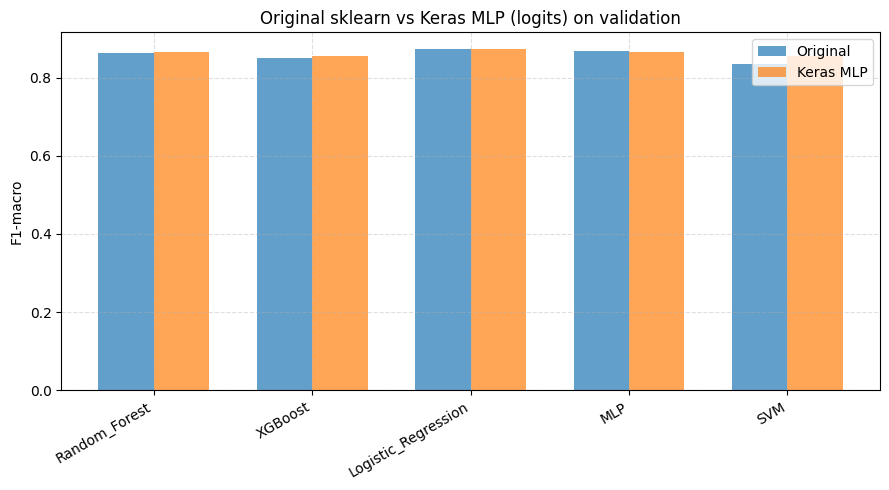

In [4]:
# -------------------------- COMPARISON TABLE & PLOT --------------------------
comp_df = pd.DataFrame(results_comparison)
print("\n" + comp_df.to_string(index=False))
comp_df.to_csv(os.path.join(RESULTS_DIR, 'classifier_vs_replacement_comparison.csv'), index=False)

plt.figure(figsize=(9, 5))
x = np.arange(len(comp_df))
width = 0.35
plt.bar(x - width/2, comp_df['Original_F1'], width, label='Original', alpha=0.7)
plt.bar(x + width/2, comp_df['MLP_F1'],     width, label='Keras MLP', alpha=0.7)
plt.xticks(x, comp_df['Model'], rotation=30, ha='right')
plt.ylabel('F1-macro')
plt.title('Original sklearn vs Keras MLP (logits) on validation')
plt.legend()
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [5]:
# -------------------------- BUILD FULL END-TO-END MODELS --------------------------
def build_full_model(keras_classifier, name: str, T: float) -> tf.keras.Model:
    """YAMNet → scaling → *Keras* classifier → temperature-scaled softmax."""
    audio_in = Input(shape=(15360,), dtype=tf.float32, name='audio')

    # 1. YAMNet embeddings
    emb = YamnetEmbedding(yamnet)(audio_in)                 # (batch, 1024)

    # 2. Standard-scale (exactly the same as training)
    scaled = (emb - scaler.mean_) / scaler.scale_

    # 3. Classifier – **always the Keras object**
    logits = keras_classifier(scaled)

    # 4. Temperature scaling + softmax
    probs = tf.nn.softmax(logits / T, name='probs')

    return Model(audio_in, probs, name=name)

# -------------------------- SAVE ALL FULL MODELS --------------------------
saved_paths = {}
for name in classifiers.keys():
    T          = temperatures[name]
    keras_clf  = keras_classifiers[name]          # <-- ONLY KERAS HERE
    print(f"\nBuilding SavedModel for {name} (T={T:.3f})")
    full_model = build_full_model(keras_clf, name, T)

    # sanity check
    dummy = np.random.randn(1, 15360).astype(np.float32)
    out   = full_model.predict(dummy, verbose=0)
    print(f"  probs sum = {out.sum():.4f}")

    save_dir = os.path.join(SAVED_MODELS_DIR, f'{name.lower()}_full')
    full_model.save(save_dir, save_format='tf')
    saved_paths[name] = save_dir
    print(f"  Saved → {save_dir}")




Building SavedModel for Random_Forest (T=4.993)
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\random_forest_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\random_forest_full\assets


  Saved → ../models/models_approach1\saved_models\random_forest_full

Building SavedModel for XGBoost (T=5.316)
  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\xgboost_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\xgboost_full\assets


  Saved → ../models/models_approach1\saved_models\xgboost_full

Building SavedModel for Logistic_Regression (T=0.981)
  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\logistic_regression_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\logistic_regression_full\assets


  Saved → ../models/models_approach1\saved_models\logistic_regression_full

Building SavedModel for MLP (T=5.475)


  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\mlp_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\mlp_full\assets


  Saved → ../models/models_approach1\saved_models\mlp_full

Building SavedModel for SVM (T=4.655)


  probs sum = 1.0000


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\svm_full\assets


INFO:tensorflow:Assets written to: ../models/models_approach1\saved_models\svm_full\assets


  Saved → ../models/models_approach1\saved_models\svm_full


In [6]:
# -------------------------- VERIFY LOADING --------------------------
print("\nVerifying SavedModels …")
for name, p in saved_paths.items():
    loaded = tf.keras.models.load_model(
        p,
        custom_objects={'YamnetEmbedding': YamnetEmbedding}
    )
    test_out = loaded.predict(np.random.randn(1, 15360).astype(np.float32), verbose=0)
    print(f"{name}: OK – probs sum = {test_out.sum():.4f}")

# -------------------------- INVENTORY (size) --------------------------
def dir_size_mb(path: str) -> float:
    total = 0.0
    for root, _, files in tf.io.gfile.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            total += tf.io.gfile.stat(fp).length
    return total / (1024 * 1024)

inventory = []
for _, row in comparison_df.iterrows():
    name = row['Model']
    size = dir_size_mb(saved_paths[name])
    inventory.append({
        'Model'   : name,
        'Val_F1'  : row['Val F1'],
        'Path'    : saved_paths[name],
        'Size_MB' : f"{size:.1f}"
    })

inv_df = pd.DataFrame(inventory).sort_values('Val_F1', ascending=False)
print("\n=== FULL-MODEL INVENTORY ===")
print(inv_df.to_string(index=False))
inv_df.to_csv(os.path.join(RESULTS_DIR, 'full_model_inventory.csv'), index=False)


Verifying SavedModels …



Random_Forest: OK – probs sum = 1.0000


XGBoost: OK – probs sum = 1.0000


Logistic_Regression: OK – probs sum = 1.0000


MLP: OK – probs sum = 1.0000


SVM: OK – probs sum = 1.0000

=== FULL-MODEL INVENTORY ===
              Model  Val_F1                                                             Path Size_MB
      Random_Forest  0.8855       ../models/models_approach1\saved_models\random_forest_full    25.4
            XGBoost  0.8745             ../models/models_approach1\saved_models\xgboost_full    25.4
Logistic_Regression  0.8721 ../models/models_approach1\saved_models\logistic_regression_full    18.1
                MLP  0.8688                 ../models/models_approach1\saved_models\mlp_full    25.4
                SVM  0.8350                 ../models/models_approach1\saved_models\svm_full    25.4
